In [1]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [38]:
pwd

'/home/jpmarceaux/Projects/KalmanFiltering/KalmanPaperFiles'

In [2]:
SEED = 2021
SAMPLES = 256
np.random.seed(SEED)

# Example 1

Performance of many exact extended filters vs batched MLE

In [3]:
# setup the datagen model
max_fogi_error_rate = 0.05
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [4]:
# make an edesign and simulate the data
maxLengths = [1,2,4,8,16]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [5]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.6s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.1s


In [6]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

In [7]:
def random_copy(max_error_rate, target_model):
    np.random.seed()
    output_model = target_model.copy()
    er = max_error_rate * np.random.rand(target_model.num_params)
    output_model.from_vector(er)
    return output_model

In [8]:
# find AGSI for the given max fogi rate
avg_fidel = 0
idx = 0
while idx < 500:
    noise_model = random_copy(0.09, target_model)
    if model_is_cptp(noise_model):
        avg_fidel += avg_gs_infidelity(noise_model, target_model)
        idx += 1
    else:
        print('non cptp model')
print(avg_fidel/500)

0.10136735741557625


In [10]:
# make many random FOGI models with approximately the same AGSI
target_avg_infidelity = 0.10
fidelity_epsilon = 0.005
num_noise_models = 3


noise_model_list = []
idx = 0
while idx < num_noise_models:
    noise_model = random_copy(0.09, target_model)
    if model_is_cptp(noise_model):
        infidel = avg_gs_infidelity(noise_model, target_model)
        if abs(infidel - target_avg_infidelity) < fidelity_epsilon:
            noise_model_list.append(noise_model)
            idx += 1
        else:
            print(f'outlying model of fidelity {infidel}')
    else:
        print('non cptp model')

outlying model of fidelity 0.11351494942762004
outlying model of fidelity 0.1314496386399625


In [11]:
# make batched MLE estimates and filter estimates for all the random models
num_samples = 256
maxLengths = [1,2,4,8]
prior_model = target_model # start at the target 
prior_covar = 0.01*np.eye(prior_model.num_params) # set the prior covar

list_of_model_lists = []
list_of_covars_lists = []
datasets = []
mle_estimates_history = []

maxlength_edesign = std.create_gst_experiment_design(maxLengths[-1])
for model in noise_model_list:
    dataset = pygsti.data.simulate_data(model, maxlength_edesign, num_samples, seed=SEED)
    datasets.append(dataset)
    mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)
    print(mserror(mle_estimates[-1], model))
    mle_estimates_history.append(mle_estimates)
    circ_list = maxlength_edesign.circuit_lists[-1]
    post_model, post_covar, saved_data = filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    vector_history = saved_data[0]
    covar_history = saved_data[1]
    list_of_model_lists.append(vector_history)
    list_of_covars_lists.append(covar_history)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.7s
0.000862964309068402


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.18it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.6s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.7s
0.000503581537230326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:23<00:00, 19.01it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.8s
0.0022735162553331797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.10it/s]


In [12]:
def make_singlerun_error_plot(plt_title, model_vectors, mdl_datagen, filter_covars, y_range, mle_estimates=None, germ_length_ranges=None, plt_spacing=25):
    """
    Make a plot of the evolution of the logarithm of error parameters and their uncertainty 
    
    --- Arguments ---
    plt_title: title of the plot
    model_vectors: list of model parameter vectors after each update
    true_params: parameters used in the datagen model
    filter_covars: list of model covariance matrices after each update
    y_range: display range for the y-axis
    mle_estimates: list of mle models after each increase in germ length
    germ_length_ranges: list of ranges of different germ lengths for the gst circuits
    plt_space: how frequently points are plotted 
    """
    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle(plt_title)

    axs[0].set_title('Estimate')
    axs[1].set_title('Total uncertainty')

    true_params = mdl_datagen.to_vector()
    for i in range(0, len(model_vectors), plt_spacing):
        params = model_vectors[i]
        error = np.log10((params-true_params)@(params-true_params))
        axs[0].scatter(i, error, c='black')
        axs[1].scatter(i, np.log10((np.trace(filter_covars[i]))), c='black')
        
    if mle_estimates is not None:
        if germ_length_ranges is None:
            raise ValueError("no germ_length_ranges. Please set circuit ranges for the mle estimates")
        for i, mdl in enumerate(mle_estimates):
            mle_error = np.log10(mserror(mdl, mdl_datagen))
            mle_line, = axs[0].plot(germ_length_ranges[i], (mle_error, mle_error), c='red', label='MLE Estimate')
            
    axs[0].legend([mle_line, ], ['MLE Estimates',])
    if y_range is not None:
        axs[0].set_ylim(y_range[0], y_range[1])
        axs[1].set_ylim(y_range[0], y_range[1])
    axs[0].set_xlabel('Circuit Index')
    axs[1].set_xlabel('Circuit Index')
    axs[0].set_ylabel('MSE [log]')

In [13]:
%matplotlib qt5
# plot the results of a particular run
i = 1
plt_spacing = 5
make_singlerun_error_plot('Evolution of Filter Estimate MSE', list_of_model_lists[i], noise_model_list[i], list_of_covars_lists[i], None, mle_estimates_history[i], germ_length_ranges, plt_spacing)

In [21]:
# make average performance plot over all the runs
fig, axes = plt.subplots(nrows=1, ncols=1)
fiducial_model = target_model.copy()
plt_spacing = 1

axes.set_ylim(-4, 0)

mle_mserrors = []

mse_points = {idx: [] for idx in range(num_noise_models)}

num_circs = len(list_of_model_lists[0])

for batch_idx, mle_estimate_set in enumerate(mle_estimates_history):
    for idx, estimate in enumerate(mle_estimate_set):
        mle_mserror = np.log10( mserror(estimate, noise_model_list[batch_idx]) )
        mle_mserrors.append(mle_mserror)
        mle_lines, = axes.plot(germ_length_ranges[idx], (mle_mserror, mle_mserror), alpha=0.4, c='blue', lw=2)
        
for idx in range(num_noise_models):
    for id_model, model_vector in enumerate(list_of_model_lists[idx]):
        if id_model % plt_spacing == 0:
            fiducial_model.from_vector(model_vector)
            mse_points[idx].append(np.log10(mserror(fiducial_model, noise_model_list[idx])))
            #agsi_points[idx].append(np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[idx])))

for idx in range(len(mse_points)):
    filter_lines, = axes.plot(range(0, num_circs, plt_spacing), mse_points[idx], alpha=0.7, c='black')

axes.set_title('MSE between estimate and datagen')
axes.legend([filter_lines, mle_lines], ['Filter Estimate', 'Batched MLE Estimates'])

axes.set_ylabel('MSE [log]')
axes.set_xlabel('Circuit Index')

plt.show()

In [22]:
# MSE distribution of MLE and Kalman Filter final estimates
fig, axes = plt.subplots(nrows=2, ncols=1)

filter_mserrors = []
for id_model, vector_list in enumerate(list_of_model_lists):
    fiducial_model.from_vector(vector_list[-1])
    filter_mserrors.append( np.log10(mserror(fiducial_model, noise_model_list[id_model])) )

axes[0].hist(filter_mserrors, color='black')
axes[0].set_title('Final Filter Estimate MSE history')
axes[1].hist(mle_mserrors, color='black')
axes[1].set_title('Finale MLE Estimate MSE history')
axes[1].set_xlabel('MSE [log]')
axes[1].set_ylabel('Number of models')
axes[0].set_ylabel('Number of models')
axes[0].set_xlim([-3.8, -2.5])
axes[1].set_xlim([-3.8, -2.5])

(-3.8, -2.5)

(-3.8, -2.5)

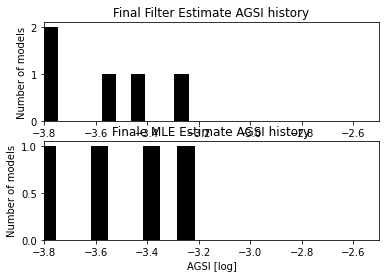

In [22]:
# AGSI distribution of MLE and Kalman Filter final estimates
fig, axes = plt.subplots(nrows=2, ncols=1)

filter_agsis = []
for id_model, vector_list in enumerate(list_of_model_lists):
    fiducial_model.from_vector(vector_list[-1])
    filter_agsis.append( np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[id_model])) )
    
mle_agsis = []
for id_model, model_list in enumerate(mle_estimates_history):
    mle_agsis.append( np.log10(avg_gs_infidelity(model_list[-1], noise_model_list[id_model])) )

axes[0].hist(filter_agsis, color='black')
axes[0].set_title('Final Filter Estimate AGSI history')
axes[1].hist(mle_agsis, color='black')
axes[1].set_title('Finale MLE Estimate AGSI history')
axes[1].set_xlabel('AGSI [log]')
axes[1].set_ylabel('Number of models')
axes[0].set_ylabel('Number of models')
axes[0].set_xlim([-3.8, -2.5])
axes[1].set_xlim([-3.8, -2.5])

# Experiment 2

Average performance of fast filtering 

In [23]:
def fast_filter_dataset(prior_model, prior_covar, dataset, circ_list, target_preds, jdict, hdict,
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    
    """
    Approximate (fast) extended filtering of the dataset in the order of the circuit list
    
    returns:
        -post. model
        -post. covar
        -saved data in order: 
        ((param_history, covar_history, prior_innovs, post_innovs, kgains)
    """
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update_approx(circ, cvec, target_preds[circ], jdict[circ], hdict[circ], clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [31]:
class ExtendedKalmanFilter():
    """
    An extended Kalman filter for gate-set tomography
    
    --- Parameters ---
    model: an underlying pygsti model
    num_params: number of parameters in the pygsti model
    P: current covariance matrix
    """
    def __init__(self, model, P0):
        self.model = model
        self.num_params = len(model.to_vector())
        self.P = P0
        
    def update(self, circ, count_vec, clip_range=[-1,1], Q=None, R_additional=None, max_itr=1, itr_eps=1e-4):
        """
        Makes an exact update to the model
        where the jacobian is calculated as the current estimate
        
        --- Arguments ---
        circ: pygsti circuit used in the update
        count_vec: vector of observed counts
        clip_range: reasonable clipping range for the parameter update
        Q: state-space covariance 
        R_additional: additional measurement covariance
        max_itr: maximum number of iterations to the update
        itr_eps: epsilon for minimum difference to end iterated updates
        
        --- Returns --- 
        innovation: the prior innovation
        kgain: the Kalman gain
        """
        prior_covar = self.P
        prior_state = self.model.to_vector()
        hilbert_dims = 2**(circ.width)
        
        for itr in range(max_itr):
            # find the predicted frequency for the circuit outcome under the model
            probs = self.model.probabilities(circ)
            p_model = vector_from_outcomes(probs, hilbert_dims)
            
            # calculate the observed frequency
            total_counts = sum(count_vec)
            observation = count_vec/total_counts

            # calculate jacobian
            jacob = matrix_from_jacob(self.model.sim.dprobs(circ), 2**circ.width)

            # calculate the covaraiance of the observation
            mean_frequency = ( count_vec+np.ones(len(count_vec)) )/( sum(count_vec)+len(count_vec) )
            R = (1/(sum(count_vec)+len(count_vec)+1))*categorical_covar(mean_frequency)
            
            # add any additional noise
            if R_additional is not None:
                R += R_additional
            if Q is None: 
                Q = 0*np.eye(self.num_params)

            # Kalman gain
            P = prior_covar + Q
            kgain = P@jacob.T@np.linalg.pinv(jacob@P@jacob.T + R, 1e-15)
            
            # Kalman update
            innovation = observation - p_model
            post_state = prior_state + kgain@innovation
            post_state = np.clip(post_state, clip_range[0], clip_range[1])
            
            # check if iteration should end
            if np.linalg.norm(post_state - prior_state) < itr_eps:
                break
            else:
                prior_state = post_state
                self.model.from_vector(post_state)
        
        # update class parameters
        self.P = (np.eye(self.num_params) - kgain@jacob)@P
        self.model.from_vector(post_state)
        return innovation, kgain 
            
    def update_approx(self, circ, count_vec, p0, jac0, hess0, clip_range, max_itr=1, itr_eps=1e-4, Q=None, R_additional=None):
        """
        Makes an approximate update to the model
        where the jacobian is approximated
        
        --- Arguments ---
        circ: pygsti circuit used in the update
        count_vec: vector of observed counts
        p0: target model prediction
        jac0: target model jacobian
        hess0: target model hessian
        clip_range: reasonable clipping range for the parameter update
        Q: state-space covariance 
        R_additional: additional measurement covariance
        max_itr: maximum number of iterations to the update
        itr_eps: epsilon for minimum difference to end iterated updates
        
        --- Returns --- 
        innov: the innovation
        kgain: the Kalman gain
        """
        prior_covar = self.P
        prior_state = self.model.to_vector()
        hilbert_dims = 2**(circ.width)
        
        for itr in range(max_itr):
            # approximate predicted frequency for the circuit outcome under the model
            #p_model = p0 + jac0@prior_state + hess0@prior_state@prior_state
            p_model = vector_from_outcomes(model.probabilities(circ), 2**circ.width)
            
            # approximate the jacobian at the current estimate
            jacob = jac0 + hess0@prior_state
            
            # calculate the observed frequency
            total_counts = sum(count_vec)
            observation = count_vec/total_counts

            # calculate the covaraiance of the observation
            mean_frequency = ( count_vec+np.ones(len(count_vec)) )/( sum(count_vec)+len(count_vec) )
            R = (1/(sum(count_vec)+len(count_vec)+1))*categorical_covar(mean_frequency)
            
            # add any additional noise
            if R_additional is not None:
                R += R_additional
            if Q is None: 
                Q = 0*np.eye(self.num_params)

            # Kalman gain
            P = prior_covar + Q
            kgain = P@jacob.T@np.linalg.pinv(jacob@P@jacob.T + R, 1e-15)
            
            # Kalman update
            innovation = observation - p_model
            post_state = prior_state + kgain@innovation
            post_state = np.clip(post_state, clip_range[0], clip_range[1])
            
            # check if iteration should end
            if np.linalg.norm(post_state - prior_state) < itr_eps:
                break
            else:
                prior_state = post_state
                self.model.from_vector(post_state)
        
        # update class parameters
        self.P = (np.eye(self.num_params) - kgain@jacob)@P
        self.model.from_vector(post_state)
        return innovation, kgain

In [26]:
# load the model jacobians and hessians and calculate target model predictions
# run "modelmat_calc.py" if you dont have the saved model matrices
jdict = load_dict('smq1Q_XYI_jacs')
hdict = load_dict('smq1Q_XYI_hess')
target_preds = dict()
for circ_list in maxlength_edesign.circuit_lists:
    for circ in circ_list:
        target_preds[circ] = vector_from_outcomes(target_model.probabilities(circ), 2**circ.width)

In [36]:
# make batched fast filter estimates for all the random models
num_samples = 256
maxLengths = [1,2,4,8]
prior_model = target_model # start at the target 
prior_covar = 0.01*np.eye(prior_model.num_params) # set the prior covar

list_of_fast_params_lists = []
list_of_fast_covars_lists = []

for idx, model in enumerate(noise_model_list):
    circ_list = maxlength_edesign.circuit_lists[-1]
    prior_model = mle_estimates_history[idx][0]
    post_model, post_covar, saved_data = fast_filter_dataset(prior_model, prior_covar, datasets[idx], circ_list, target_preds, jdict, hdict,
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    vector_history = saved_data[0]
    covar_history = saved_data[1]
    list_of_fast_params_lists.append(vector_history)
    list_of_fast_covars_lists.append(covar_history)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:02<00:00, 163.92it/s]


In [37]:
# make average performance plot over all the fast runs
fig, axes = plt.subplots(nrows=1, ncols=1)
fiducial_model = target_model.copy()
plt_spacing = 1

axes.set_ylim(-4, 0)

mle_mserrors = []

mse_points = {idx: [] for idx in range(num_noise_models)}

num_circs = len(list_of_model_lists[0])

for batch_idx, mle_estimate_set in enumerate(mle_estimates_history):
    for idx, estimate in enumerate(mle_estimate_set):
        mle_mserror = np.log10( mserror(estimate, noise_model_list[batch_idx]) )
        mle_mserrors.append(mle_mserror)
        mle_lines, = axes.plot(germ_length_ranges[idx], (mle_mserror, mle_mserror), alpha=0.4, c='blue', lw=2)
        
for idx in range(num_noise_models):
    for id_model, model_vector in enumerate(list_of_fast_params_lists[idx]):
        if id_model % plt_spacing == 0:
            fiducial_model.from_vector(model_vector)
            mse_points[idx].append(np.log10(mserror(fiducial_model, noise_model_list[idx])))
            #agsi_points[idx].append(np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[idx])))

for idx in range(len(mse_points)):
    filter_lines, = axes.plot(range(0, num_circs, plt_spacing), mse_points[idx], alpha=0.7, c='black')

axes.set_title('MSE between estimate and datagen')
axes.legend([filter_lines, mle_lines], ['Filter Estimate', 'Batched MLE Estimates'])

axes.set_ylabel('MSE [log]')
axes.set_xlabel('Circuit Index')

plt.show()

# Experiment 3

Posterior Fit Performance compared with CPTP model

In [67]:
from scipy.stats import multinomial

def experimental_loglikelihood(circuit_list, dataset, model):
    """
    multinomial likelihood of observations under the given model 
    
    assumes all the circuits have the same number of qubits
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        pmat = np.vstack([pmat, p_model])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

def max_loglikelihood(circuit_list, dataset):
    """
    max loglikelihood 
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        frequency = count_vec/sum(count_vec)
        pmat = np.vstack([pmat, frequency])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

In [86]:
cptp_target = std.target_model('CPTP')

In [87]:
# setup the datagen model
max_fogi_error_rate = 0.12
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
fogi_target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [88]:
avg_gs_infidelity(mdl_datagen, fogi_target_model)

0.11770128705202798

In [89]:
# make an edesign and simulate the data
maxLengths = [1,2,4]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(cptp_target, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [90]:
cptp_mle_estimates, edesigns = make_mle_estimates(dataset, std, cptp_target, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 3.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 6.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 7.8s


In [91]:
prior_cptp_covar = 0.1*np.eye(cptp_target.num_params)

In [93]:
post_cptp_mle1seed, cptp_mle1_covar, saved_data = filter_dataset(cptp_mle_estimates[0], prior_cptp_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:22<00:00, 12.58it/s]


In [94]:
post_cptp_targetseed, cptp_targetseed_covar, saved_data = filter_dataset(cptp_target, prior_cptp_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:25<00:00, 11.28it/s]


In [95]:
max_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset)

-847.0902220850269

In [96]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle_estimates[0])

-999.9591684826103

In [97]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle_estimates[-1])

-971.311268200813

In [98]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_zero_ekf.model)

-2404.615271471128

In [99]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle1_ekf.model)

-971.329735215731

In [100]:
fogi_mle_estimates, edesigns = make_mle_estimates(dataset, std, fogi_target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.2s


In [103]:
prior_fogi_covar = 0.1*np.eye(fogi_target_model.num_params)

In [111]:
post_fogi_mle1seed, mle1_covar, saved_data = filter_dataset(fogi_mle_estimates[0], prior_fogi_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:13<00:00, 21.09it/s]


In [105]:
post_fogi_targetseed, targetseed_covar, saved_data = filter_dataset(fogi_target_model, prior_fogi_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:13<00:00, 21.09it/s]


In [112]:
max_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset)

-847.0902220850269

In [113]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, fogi_mle_estimates[0])

-994.3977133457206

In [114]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, fogi_mle_estimates[-1])

-976.8536459996624

In [115]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, post_fogi_mle1seed)

-977.3734515824826

In [117]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, post_fogi_targetseed)

-977.0866225452755

In [ ]:
log_likelihoods = [

In [86]:
def plot_covar_evals(covar_dict):
    evals = []
    for c in range(num_circs):
        circ_eval, _ = np.linalg.eig(covar_dict[c])
        evals.append(circ_eval)
    plt.matshow(abs(np.array(evals).T))
    
def plot_covar_svals(covar_dict):
    svals = []
    for c in range(num_circs):
        _, circ_sval, _ = np.linalg.svd(covar_dict[c])
        svals.append(circ_sval)
    plt.matshow(abs(np.array(svals).T))

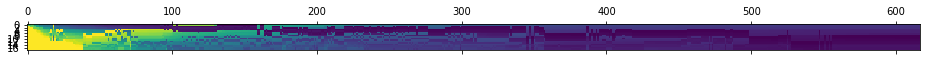

In [87]:
plot_covar_evals(mle1_covars)

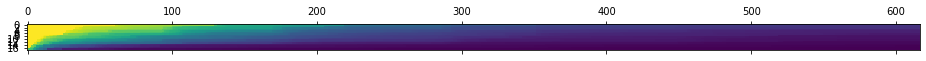

In [88]:
plot_covar_svals(mle1_covars)

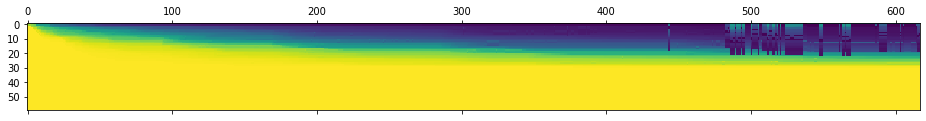

In [91]:
plot_covar_evals(cptp_mle1_covars)

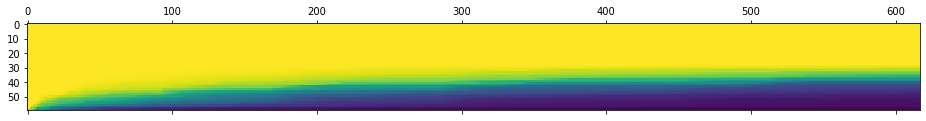

In [92]:
plot_covar_svals(cptp_mle1_covars)

In [ ]:
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
datagen_models = []
estimates = []
data_sets = []
edesign_sets = []
for e in error_strengths:
    ar = e * np.random.rand(len(ar))
    mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
    datagen_models.append(mdl_datagen.copy())
    est, ds, edesigns = make_mle_estimates(mdl_datagen, target_model, [1, 2, 4, 8, 16], samples)
    estimates.append(est)
    data_sets.append(ds)
    edesign_sets.append(edesigns)

In [10]:
def random_hs_fogi_model(max_error_rate, hs_target_model):
    output_model = hs_target_model.copy()
    basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
    gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, hs_target_model.state_space, elementary_errorgen_types='HS')
    output_model.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
    target_model = output_model.copy()
    ar = output_model.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
    np.random.seed()
    ar = max_error_rate * np.random.rand(len(ar))
    output_model.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
    return output_model, target_model